# 0) Initialization

In [1]:
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib as mpl
import datetime
from skimage import measure
from scipy import ndimage
import scipy.integrate as sin
from scipy.optimize import curve_fit

import pickle
import sys

In [2]:
fz = 15
lw = 3

In [3]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [4]:
def index_date(time_array,date_string):
    return [i for i, x in enumerate(time_array.sel({'time':date_string})==time_array) if x]

In [5]:
def date_index(time_array,time_index):
    return time_array[time_index].values

In [6]:
path = '/nfs/twcroninlab002/tbeucler/ERA5/ERA5_LHF_SHF/'

In [7]:
MSE = xr.open_mfdataset(path+'????/??MSE.nc',combine='by_coords')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [167]:
PRECIP = xr.open_mfdataset(path+'????/??PRECIP.nc',combine='by_coords')

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [171]:
PRECIP['tp']

<xarray.DataArray 'tp' (time: 166560, latitude: 721, longitude: 1440)>
dask.array<shape=(166560, 721, 1440), dtype=float32, chunksize=(744, 721, 1440)>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2018-12-31T23:00:00
Attributes:
    units:      m
    long_name:  Total precipitation

# 1) Save IQR,MED,MMI of column water vapor in time

In [9]:
dt = 3600
tcoor = dt*np.arange(0,MSE.time.shape[0])

In [10]:
latmin = -30
latmax = 30
lonmin = 300
lonmax = 360

MSEAtl = MSE['p62.162'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = MSE.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = MSE.latitude.sel({'latitude':slice(latmax,latmin)})

In [11]:
CWVAtl = (MSE['p62.162'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})-\
MSE['p61.162'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)}))/2.5e6

In [172]:
PRECAtl = 1e3*PRECIP['tp'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)}) # In mm/day or kg/m2/day

In [12]:
YEAR = np.linspace(2000,2018,19).astype(int)
print(YEAR)

[2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013
 2014 2015 2016 2017 2018]


In [13]:
year = 1993
date1 = str(year)+'-01-01T00:00:00'
date2 = str(year)+'-12-31T23:00:00'
print(date1,date2)

1993-01-01T00:00:00 1993-12-31T23:00:00


Interquartile range

In [ ]:
IQ = {}
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,'                ',end='\r')
    date1 = str(year)+'-01-01T00:00:00'
    date2 = str(year)+'-12-31T23:00:00'
    IQ[str(year)] = np.zeros((MSEAtl.time.sel({'time':slice(date1,date2)}).shape[0],))
    IQ[str(year)][:] = np.percentile(MSEAtl.sel({'time':slice(date1,date2)}),75,axis=(1,2))-\
    np.percentile(MSEAtl.sel({'time':slice(date1,date2)}),25,axis=(1,2))

Median

In [ ]:
MED = {}
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,'                ',end='\r')
    date1 = str(year)+'-01-01T00:00:00'
    date2 = str(year)+'-12-31T23:00:00'
    MED[str(year)] = np.zeros((MSEAtl.time.sel({'time':slice(date1,date2)}).shape[0],))
    MED[str(year)][:] = np.percentile(MSEAtl.sel({'time':slice(date1,date2)}),50,axis=(1,2))

Moist Margin Index

In [ ]:
dx = 110/4 #km
L_CONTOUR = {}
it_tot = 0
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year)
    date1 = str(year)+'-01-01T00:00:00'
    date2 = str(year)+'-12-31T23:00:00'
    Nt = MSEAtl.time.sel({'time':slice(date1,date2)}).shape[0]
    L_CONTOUR[str(year)] = np.zeros((Nt,))
    for it in range(Nt):
        print('it=',it,' & it_tot=',it_tot,'               ',end='\r')
        Contour = curve.get_contours(MSEAtl[it_tot,:,:]>MED_data['Median_MSE'][str(year)][it])
        L = 0
        for j,contour in enumerate(Contour):
            plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='k')
            L += np.sum(contour*dx)
        L_CONTOUR[str(year)][it] = L
        it_tot+=1

i= 0  & year= 2000


Save interquartile range and median time series to not have to re-calculate it

In [121]:
# hf = open('PKL_DATA/8_13_IQ.pkl','wb')
# hf = open('PKL_DATA/10_1_MED.pkl','wb')
# # IQ_data = { "Interquartile_range_MSE" : IQ, "time" : MSEAtl.time }
# # pickle.dump(IQ_data,hf)
# MED_data = { "Median_MSE" : MED, "time" : MSEAtl.time }
# pickle.dump(MED_data,hf) 
# hf.close()

# 2) Analyze most aggregated case (as measured by IQ range) among all years

## 2.1) Load data and select cases

In [14]:
hf = open('PKL_DATA/8_13_IQ.pkl','rb')
IQ_data = pickle.load(hf)

In [15]:
hf = open('PKL_DATA/10_1_MED.pkl','rb')
MED_data = pickle.load(hf)

In [16]:
CON_data = {}
for i,year in enumerate(YEAR):
    print('i=',i,' & year=',year,' ',end='\r')
    hf = open('PKL_DATA/10_2_CONTOURL'+str(year)+'.pkl','rb')
    tmp = pickle.load(hf)
    CON_data[year] = tmp['Tot_Contour_km'][str(year)]

In [17]:
YEAR = np.linspace(2000,2018,19).astype(int)
# Max,min of interquartile range
max_year = np.zeros((YEAR.size,))
min_year = np.copy(max_year)
# Max,min of contour length
maxC_year = np.copy(max_year)
minC_year = np.copy(max_year)
for i,year in enumerate(YEAR):
    max_year[i] = IQ_data['Interquartile_range_MSE'][str(year)].max()
    min_year[i] = IQ_data['Interquartile_range_MSE'][str(year)].min()
    maxC_year[i] = CON_data[year].max()
    minC_year[i] = CON_data[year].min()

In [18]:
print('Max of IQ range')
for data in max_year:
    sys.stdout.write('  ')
    sys.stdout.write('{:03.0f}'.format(data/2.5e6))
print('\nMin of IQ range')
for data in min_year:
    sys.stdout.write('  ')
    sys.stdout.write('{:03.0f}'.format(data/2.5e6))
print('\nMax of contour L')
for data in maxC_year:
    sys.stdout.write('  ')
    sys.stdout.write('{:04.1f}'.format(data/1e6))
print('\nMin of contour L')
for data in minC_year:
    sys.stdout.write('  ')
    sys.stdout.write('{:04.1f}'.format(data/1e6))

Max of IQ range
  036  036  037  037  036  037  036  036  037  035  040  037  036  036  036  034  036  037  034
Min of IQ range
  017  016  016  018  017  018  016  017  019  017  017  017  017  016  018  018  017  019  018
Max of contour L
  17.8  17.2  18.2  17.7  18.7  17.8  18.8  17.4  17.3  17.5  18.5  19.2  17.8  19.5  16.6  18.7  18.9  16.8  18.7
Min of contour L
  06.3  05.8  05.8  05.2  04.7  05.7  05.1  05.1  05.7  05.9  04.8  05.3  05.7  06.0  05.4  05.3  05.5  05.3  00.0

## 2.2) Case 1 selected on IQ range, Slow aggregation fast disaggregation

In [19]:
imax = np.argmax(IQ_data['Interquartile_range_MSE']['2010'])
print('imax=',imax,' & IQ[imax]=',IQ_data['Interquartile_range_MSE']['2010'][imax]/2.5e6)

imax= 2433  & IQ[imax]= 39.9507968


/home/tbeucler/miniconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'IQ [kg/m2]')

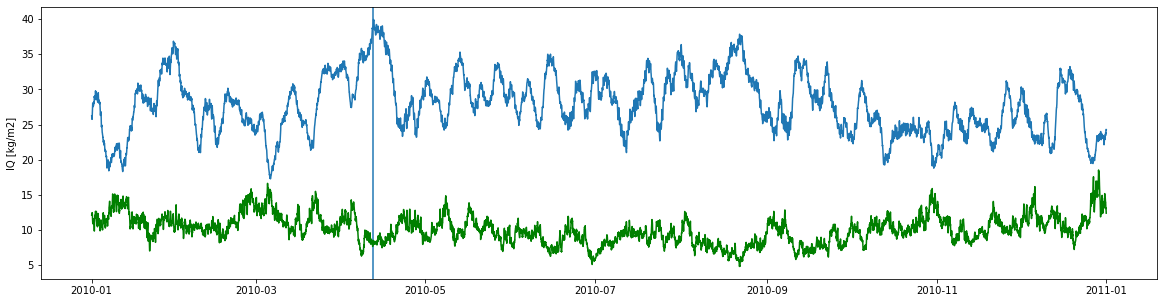

In [20]:
year = 2010
date1 = str(year)+'-01-01T00:00:00'
date2 = str(year)+'-12-31T23:00:00'
t2000 = MSEAtl.time.sel({'time':slice(date1,date2)})

plt.figure(figsize=(20,5))
plt.plot(t2000,IQ_data['Interquartile_range_MSE']['2010']/2.5e6)
plt.axvline(t2000[2433].values)
plt.plot(t2000,CON_data[2010]/1e6,color='g')
plt.ylabel('IQ [kg/m2]')

In [21]:
imin_left = np.argmin(IQ_data['Interquartile_range_MSE']['2010'][imax-1000:imax])+imax-1000

In [22]:
imin_right = np.argmin(IQ_data['Interquartile_range_MSE']['2010'][imax:imax+1000])+imax

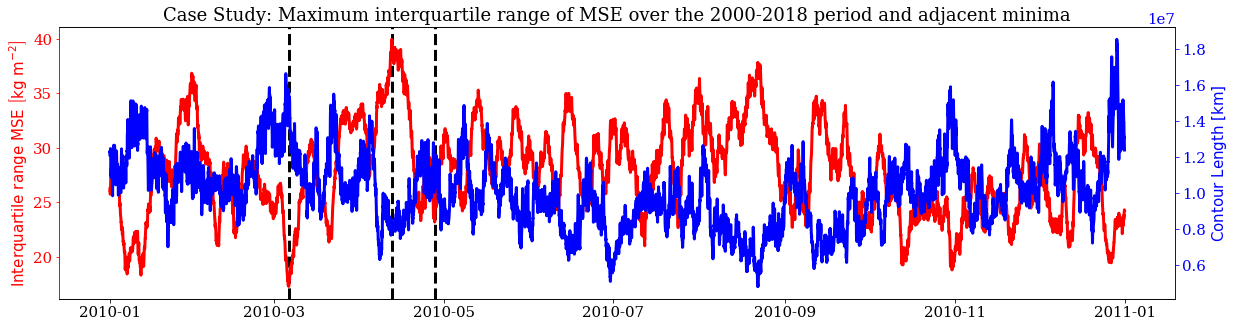

In [122]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
ax.axvline(t2000[imax].values,color='k',linestyle='--')
ax.axvline(t2000[imin_left].values,color='k',linestyle='--')
ax.axvline(t2000[imin_right].values,color='k',linestyle='--')

ax2.plot(t2000,CON_data[2010],color='b')
ax2.spines['left'].set_color('r')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax2.set_ylabel(r'$\mathrm{Contour\ Length\ \left[km\right]}$',color='b')

ax.plot(t2000,IQ_data['Interquartile_range_MSE']['2010']/2.5e6,color='r')
ax.spines['left'].set_color('r')
ax.set_ylabel(r'$\mathrm{Interquartile\ range\ MSE\ \left[kg\ m^{-2}\right]}$',color='r')
ax.tick_params(axis='y', colors='r')
ax.set_title('Case Study: Maximum interquartile range of MSE over the 2000-2018 period and adjacent minima')

# Save figure
path_home = '/home/tbeucler/'
plt.savefig(path_home+'Timeseries_CASE1.pdf',format='pdf')

In [24]:
LSM = xr.open_mfdataset(path+'ERA_LANDSEAMASK.nc')

/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [25]:
iJan1_2010 = index_date(MSEAtl.time,str(2010)+'-01-01T00:00:00')[0]

i= 0  & date= 2010-03-06T07:00:00.000000000
Defining moist margin
Measuring contour length
i= 1  & date= 2010-04-12T09:00:00.000000000
Defining moist margin
Measuring contour length
i= 2  & date= 2010-04-27T20:00:00.000000000
Defining moist margin
Measuring contour length


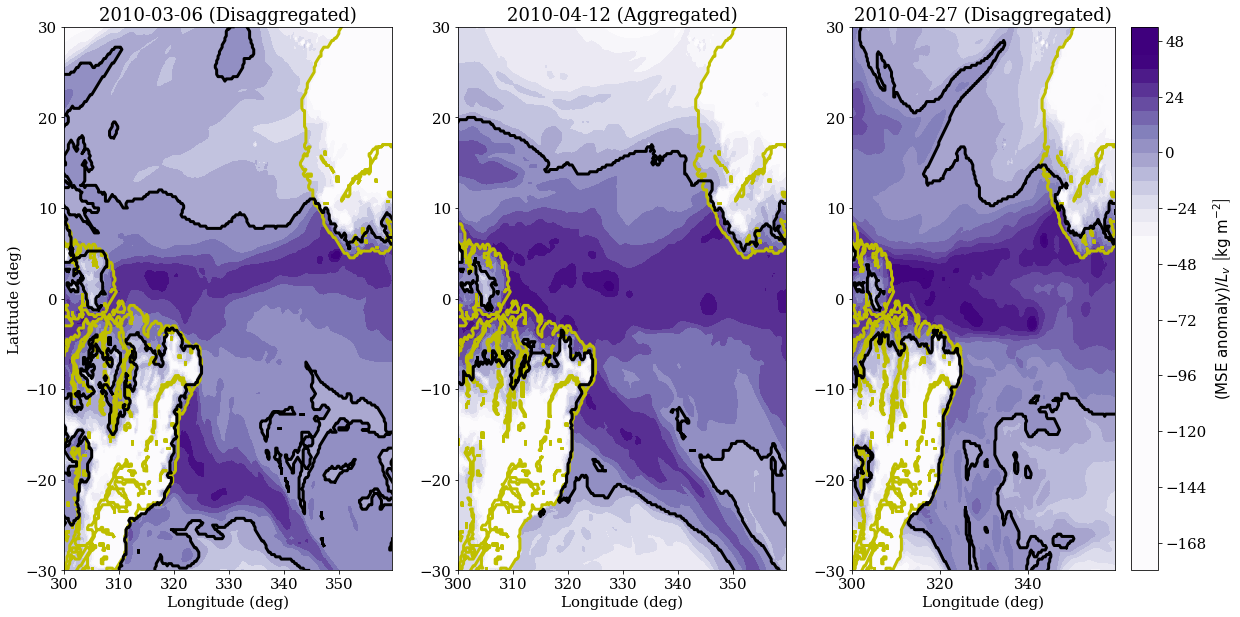

In [176]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

dx = 110/4
#vmin = 2.6e9
#vmax = 2.85e9
vmin = -40
vmax = 40

Tstr2010 = [imin_left,imax,imin_right]

plt.figure(figsize=(20,10))

for i,it2010 in enumerate(Tstr2010):
    it = it2010+iJan1_2010
    date = MSEAtl.time[it].values
    print('i=',i,' & date=',date)
    plt.subplot(1,3,i+1)
    plt.contourf(lonAtl,latAtl,(MSEAtl.sel({'time':date})-MED_data['Median_MSE']['2010'][it2010])/2.5e6,
                 cmap='Purples',levels=40,vmin=vmin,vmax=vmax)
    
    if i==2: 
        cbar = plt.colorbar()
        cbar.ax.get_yaxis().labelpad = 5
        cbar.ax.set_ylabel(r'$\left(\mathrm{MSE\ anomaly}\right)/L_{v}\ \left[\mathrm{kg\ m^{-2}}\right]$', rotation=90)
        
    Land = curve.get_contours(LSM.lsm.sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})[0,:,:]>0.99)
    for j,contour in enumerate(Land):
        plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='y')
    
    print('Defining moist margin')
    Contour = curve.get_contours(MSEAtl.sel({'time':date})>MED_data['Median_MSE']['2010'][it2010])
    print('Measuring contour length')
    L = 0
    for j,contour in enumerate(Contour):
        plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='k')
        L += np.sum(contour*dx)
    
    if i==0: posttit = ' (Disaggregated)'
    elif i==1: posttit = ' (Aggregated)'
    elif i==2: posttit = ' (Disaggregated)'
    plt.title(str(date)[:10]+posttit)
    
    plt.xlabel('Longitude (deg)')
    if i==0: plt.ylabel('Latitude (deg)')
    
# Save figure
path_home = '/home/tbeucler/'
plt.savefig(path_home+'Map_CASE1.pdf',format='pdf')

## 2.3) Case 2 selected on C length, fast aggregation slow disaggregation

In [123]:
iminC = np.argmin(CON_data[2004])
print('imin=',iminC,' & CON[imin]=',CON_data[2004][iminC]/1e6)

imin= 5976  & CON[imin]= 4.7437775


Text(0, 0.5, 'IQ [kg/m2]')

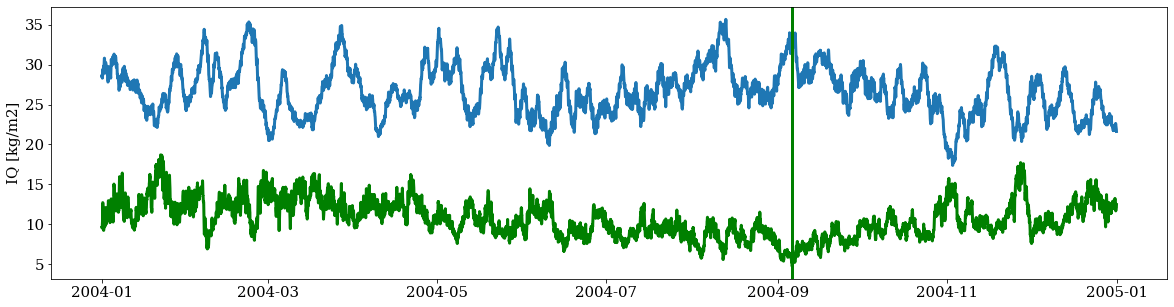

In [124]:
year = 2004
date1 = str(year)+'-01-01T00:00:00'
date2 = str(year)+'-12-31T23:00:00'
t2004 = MSEAtl.time.sel({'time':slice(date1,date2)})

plt.figure(figsize=(20,5))
plt.plot(t2004,IQ_data['Interquartile_range_MSE'][str(year)]/2.5e6)
plt.axvline(t2004[iminC].values,color='g')
plt.plot(t2004,CON_data[year]/1e6,color='g')
plt.ylabel('IQ [kg/m2]')

In [125]:
imax_left = np.argmax(CON_data[year][iminC-500:iminC])+iminC-500

In [126]:
imax_right = np.argmax(CON_data[year][iminC:iminC+1000])+iminC

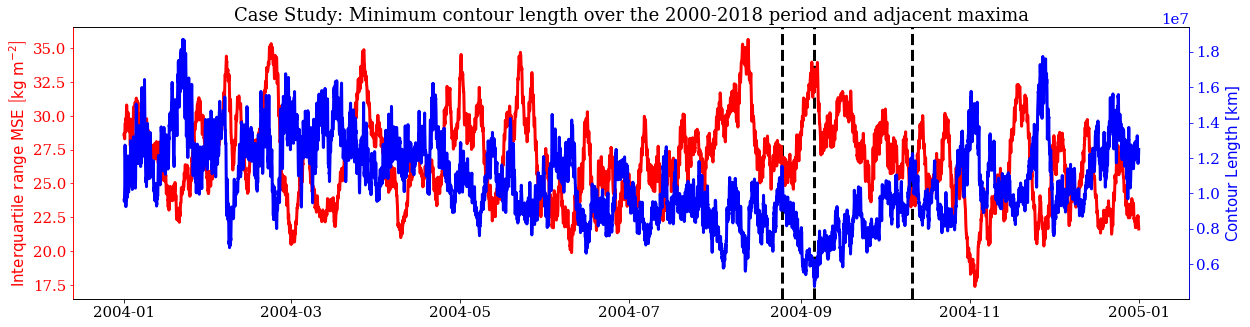

In [127]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(figsize=(20,5))
ax2 = ax.twinx()
ax.axvline(t2004[iminC].values,color='k',linestyle='--')
ax.axvline(t2004[imax_left].values,color='k',linestyle='--')
ax.axvline(t2004[imax_right].values,color='k',linestyle='--')

ax2.plot(t2004,CON_data[2004],color='b')
ax2.spines['left'].set_color('r')
ax2.spines['right'].set_color('b')
ax2.tick_params(axis='y', colors='b')
ax2.set_ylabel(r'$\mathrm{Contour\ Length\ \left[km\right]}$',color='b')

ax.plot(t2004,IQ_data['Interquartile_range_MSE']['2004']/2.5e6,color='r')
ax.spines['left'].set_color('r')
ax.set_ylabel(r'$\mathrm{Interquartile\ range\ MSE\ \left[kg\ m^{-2}\right]}$',color='r')
ax.tick_params(axis='y', colors='r')
ax.set_title('Case Study: Minimum contour length over the 2000-2018 period and adjacent maxima')

# Save figure
path_home = '/home/tbeucler/'
plt.savefig(path_home+'Timeseries_CASE2.pdf',format='pdf')

In [31]:
iJan1_2004 = index_date(MSEAtl.time,str(2004)+'-01-01T00:00:00')[0]

i= 0  & date= 2004-08-25T07:00:00.000000000
Defining moist margin
Measuring contour length
i= 1  & date= 2004-09-06T00:00:00.000000000
Defining moist margin
Measuring contour length
i= 2  & date= 2004-10-11T08:00:00.000000000
Defining moist margin
Measuring contour length


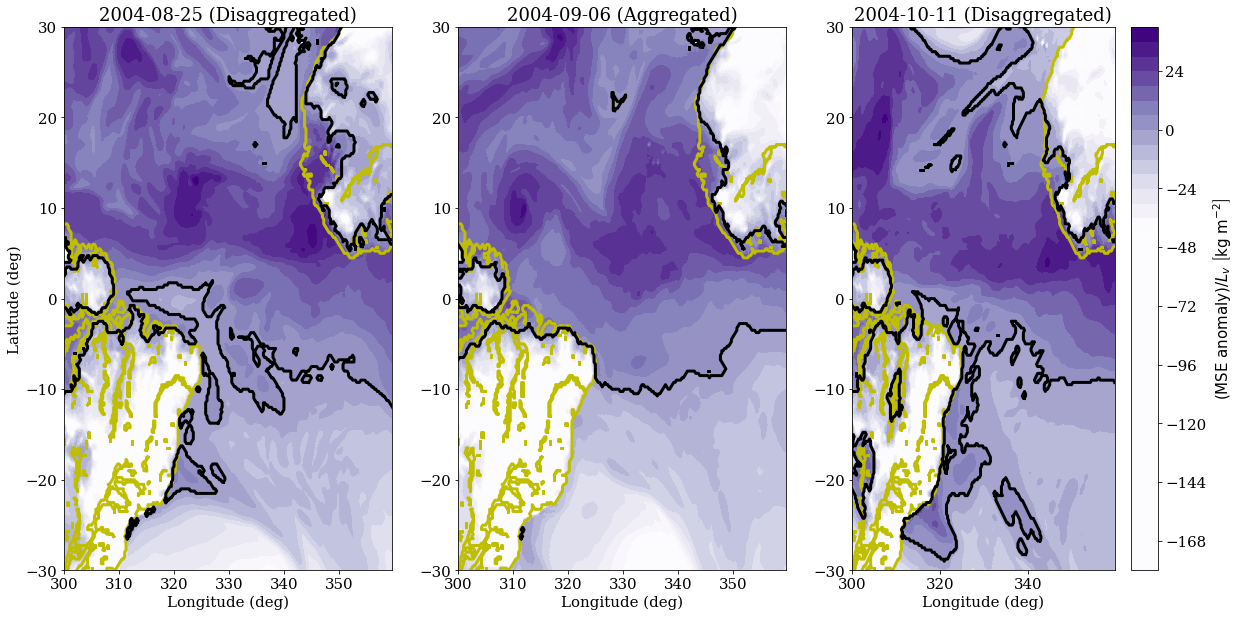

In [59]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

dx = 110/4
#vmin = 2.6e9
#vmax = 2.85e9
vmin = -40
vmax = 40

Tstr2004 = [imax_left,iminC,imax_right]

plt.figure(figsize=(20,10))

for i,it2004 in enumerate(Tstr2004):
    it = it2004+iJan1_2004
    date = MSEAtl.time[it].values
    print('i=',i,' & date=',date)
    plt.subplot(1,3,i+1)
    plt.contourf(lonAtl,latAtl,(MSEAtl.sel({'time':date})-MED_data['Median_MSE']['2004'][it2004])/2.5e6,
                 cmap='Purples',levels=40,vmin=vmin,vmax=vmax)
    
    Land = curve.get_contours(LSM.lsm.sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})[0,:,:]>0.99)
    for j,contour in enumerate(Land):
        plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='y')
    
    print('Defining moist margin')
    Contour = curve.get_contours(MSEAtl.sel({'time':date})>MED_data['Median_MSE']['2004'][it2004])
    print('Measuring contour length')
    L = 0
    for j,contour in enumerate(Contour):
        plt.plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='k')
        L += np.sum(contour*dx)
    
    if i==2: 
        cbar = plt.colorbar()
        cbar.ax.get_yaxis().labelpad = 5
        cbar.ax.set_ylabel(r'$\left(\mathrm{MSE\ anomaly}\right)/L_{v}\ \left[\mathrm{kg\ m^{-2}}\right]$', rotation=90)
    if i==0: posttit = ' (Disaggregated)'
    elif i==1: posttit = ' (Aggregated)'
    elif i==2: posttit = ' (Disaggregated)'
    plt.title(str(date)[:10]+posttit)
    
    plt.xlabel('Longitude (deg)')
    if i==0: plt.ylabel('Latitude (deg)')
    
# Save figure
path_home = '/home/tbeucler/'
plt.savefig(path_home+'Map_CASE2.pdf',format='pdf')

## 2.4) Save all cases for future use

In [60]:
hf = open('PKL_DATA/10_7_CASES.pkl','wb')
CASE_data = {"Case1":(imax,imin_left,imin_right,iJan1_2010),"Case2":(iminC,imax_left,imax_right,iJan1_2004)}
pickle.dump(CASE_data,hf)

# 3) Figure 1b = PDF CWV at different times

## 3.1) Case 1

For now build PDF by taking one day in each direction of the min/max

In [61]:
year = 2010
date1 = str(year)+'-01-01T00:00:00'
date2 = str(year)+'-12-31T23:00:00'
t2010 = MSEAtl.time.sel({'time':slice(date1,date2)})

In [62]:
CWV_PDF1_LEFT,LEFT1edges = np.histogram(CWVAtl[(iJan1_2010+imin_left-24):(iJan1_2010+imin_left+24),:,:],bins=100,density=True)
CWV_PDF1_MID,MID1edges = np.histogram(CWVAtl[(iJan1_2010+imax-24):(iJan1_2010+imax+24),:,:],bins=100,density=True)
CWV_PDF1_RIGHT,RIGHT1edges = np.histogram(CWVAtl[(iJan1_2010+imin_right-24):(iJan1_2010+imin_right+24),:,:],bins=100,density=True)

In [48]:
# Bin 6-hourly to put uncertainty bounds on PDF
# Left disag.
hour = imin_left-24
for i in range(8):
    print('i=',i,' & it=',hour,'              ',end='\r')
    PDFtmp,tmp = np.histogram(CWVAtl[(iJan1_2010+hour):(iJan1_2010+hour+7),:,:],bins=LEFT1edges,density=True)
    hour += 6
    if i==0: LEFT1_min = PDFtmp; LEFT1_max = PDFtmp;
    else: LEFT1_min = np.minimum(LEFT1_min,PDFtmp); LEFT1_max = np.maximum(LEFT1_max,PDFtmp)
# Middle agg.
hour = imax-24
for i in range(8):
    print('i=',i,' & it=',hour,'              ',end='\r')
    PDFtmp,tmp = np.histogram(CWVAtl[(iJan1_2010+hour):(iJan1_2010+hour+7),:,:],bins=MID1edges,density=True)
    hour += 6
    if i==0: MID1_min = PDFtmp; MID1_max = PDFtmp;
    else: MID1_min = np.minimum(MID1_min,PDFtmp); MID1_max = np.maximum(MID1_max,PDFtmp)
# Right disag.
hour = imin_right-24
for i in range(8):
    print('i=',i,' & it=',hour,'              ',end='\r')
    PDFtmp,tmp = np.histogram(CWVAtl[(iJan1_2010+hour):(iJan1_2010+hour+7),:,:],bins=RIGHT1edges,density=True)
    hour += 6
    if i==0: RIGHT1_min = PDFtmp; RIGHT1_max = PDFtmp;
    else: RIGHT1_min = np.minimum(RIGHT1_min,PDFtmp); RIGHT1_max = np.maximum(RIGHT1_max,PDFtmp)

In [63]:
SPINrgb = np.array([255,126,14])/255
COALrgb = np.array([43,160,43])/255
COARrgb = np.array([31,119,179])/255

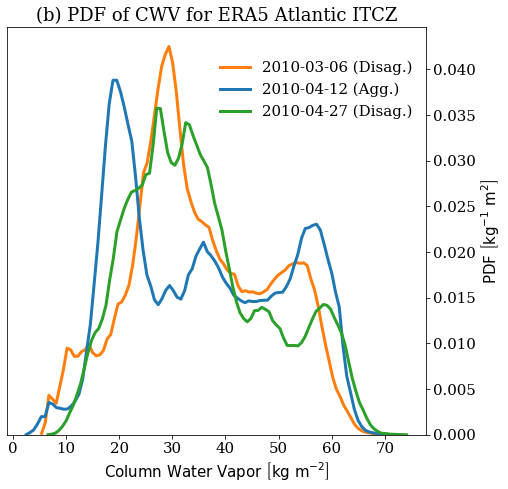

In [64]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(figsize=(7.5,7.5))

# Shading goes in the back
# ax.fill_between(edgTObin(LEFT1edges),LEFT1_min,LEFT1_max,color=1-(1-SPINrgb)/2)
# ax.fill_between(edgTObin(MID1edges),MID1_min,MID1_max,color=1-(1-COARrgb)/2)
# ax.fill_between(edgTObin(RIGHT1edges),RIGHT1_min,RIGHT1_max,color=1-(1-COALrgb)/2)

LEFT1line = ax.plot(edgTObin(LEFT1edges),CWV_PDF1_LEFT,color=SPINrgb,
                    label=str(date_index(MSEAtl.time,imin_left+iJan1_2010))[:10]+' (Disag.)')
MIDline = ax.plot(edgTObin(MID1edges),CWV_PDF1_MID,color=COARrgb,
                  label=str(date_index(MSEAtl.time,imax+iJan1_2010))[:10]+' (Agg.)')
RIGHTline = ax.plot(edgTObin(RIGHT1edges),CWV_PDF1_RIGHT,color=COALrgb,
                    label=str(date_index(MSEAtl.time,imin_right+iJan1_2010))[:10]+' (Disag.)')
leg = ax.legend(frameon=False,bbox_to_anchor=(0,0,1,0.95))
ax.set_xlabel(r'$\mathrm{Column\ Water\ Vapor\ }\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$')
ax.set_ylim((0,ax.get_ylim()[1]))
ax.set_title('(b) PDF of CWV for ERA5 Atlantic ITCZ')
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()

plt.draw()

# Save figure
path_home = '/home/tbeucler/'
plt.savefig(path_home+'Fig1b_CASE1.pdf',format='pdf')

## 3.2) Case 2

In [66]:
year = 2004
date1 = str(year)+'-01-01T00:00:00'
date2 = str(year)+'-12-31T23:00:00'
t2004 = MSEAtl.time.sel({'time':slice(date1,date2)})

In [67]:
CWV_PDF2_LEFT,LEFT2edges = np.histogram(CWVAtl[(iJan1_2004+imin_left-24):(iJan1_2004+imin_left+24),:,:],bins=100,density=True)
CWV_PDF2_MID,MID2edges = np.histogram(CWVAtl[(iJan1_2004+imax-24):(iJan1_2004+imax+24),:,:],bins=100,density=True)
CWV_PDF2_RIGHT,RIGHT2edges = np.histogram(CWVAtl[(iJan1_2004+imin_right-24):(iJan1_2004+imin_right+24),:,:],bins=100,density=True)

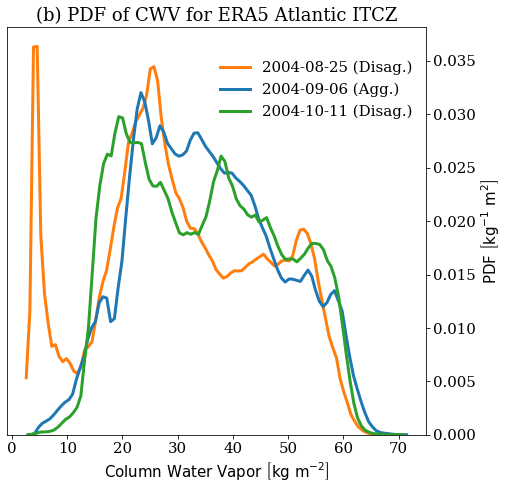

In [68]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(figsize=(7.5,7.5))

# Shading goes in the back
# ax.fill_between(edgTObin(LEFT1edges),LEFT1_min,LEFT1_max,color=1-(1-SPINrgb)/2)
# ax.fill_between(edgTObin(MID1edges),MID1_min,MID1_max,color=1-(1-COARrgb)/2)
# ax.fill_between(edgTObin(RIGHT1edges),RIGHT1_min,RIGHT1_max,color=1-(1-COALrgb)/2)

LEFTline = ax.plot(edgTObin(LEFT2edges),CWV_PDF2_LEFT,color=SPINrgb,
                    label=str(date_index(MSEAtl.time,imax_left+iJan1_2004))[:10]+' (Disag.)')
MIDline = ax.plot(edgTObin(MID2edges),CWV_PDF2_MID,color=COARrgb,
                  label=str(date_index(MSEAtl.time,iminC+iJan1_2004))[:10]+' (Agg.)')
RIGHTline = ax.plot(edgTObin(RIGHT2edges),CWV_PDF2_RIGHT,color=COALrgb,
                    label=str(date_index(MSEAtl.time,imax_right+iJan1_2004))[:10]+' (Disag.)')
leg = ax.legend(frameon=False,bbox_to_anchor=(0,0,1,0.95))
ax.set_xlabel(r'$\mathrm{Column\ Water\ Vapor\ }\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$')
ax.set_ylim((0,ax.get_ylim()[1]))
ax.set_title('(b) PDF of CWV for ERA5 Atlantic ITCZ')
plt.gca().yaxis.set_label_position("right")
plt.gca().yaxis.tick_right()

plt.draw()

# Save figure
path_home = '/home/tbeucler/'
plt.savefig(path_home+'Fig1b_CASE2.pdf',format='pdf')

# 4) Figure 2b/d: Potential, Landau, Contour

We will use case1 as our case study.  
Define value of zero potential; use median value of MSE over full period.

In [26]:
year = 2010
date1 = str(year)+'-01-01T00:00:00'
date2 = str(year)+'-12-31T23:00:00'
t2010 = MSEAtl.time.sel({'time':slice(date1,date2)})

In [27]:
bin0=np.percentile(a=MSEAtl[(iJan1_2010+imin_left):(iJan1_2010+imin_right+1),:,:],q=50,axis=(0,1,2))

Calculate PDF of MSE over same time period

In [28]:
MSE_PDF,PDFedges = np.histogram(MSEAtl[(iJan1_2010+imin_left):(iJan1_2010+imin_right+1),:,:],bins=100,density=True)

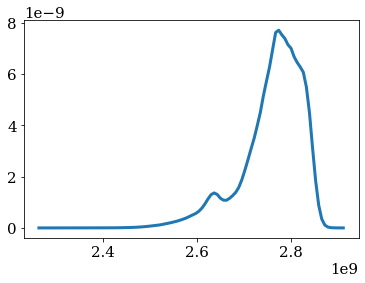

In [29]:
plt.plot(edgTObin(PDFedges),MSE_PDF)

Calculate time-tendency of MSE

In [55]:
dt = 3600
#ileftV = (iJan1_2010+imax-1-7*24)
ileftV = (iJan1_2010+imin_left)
#irightV = (iJan1_2010+imax+7*24)
#irightV = (iJan1_2010+imin_right)
irightV = iJan1_2010+imax

In [56]:
MSEAtl_res = MSEAtl[ileftV-1:irightV+2,:,:].values # If can't fit in the memory, can't calculate potential

The kernel crashes if the MSE tendency is calculated over the full temporal range. We'll calculate the MSE tendency over smaller ranges of length 100 and concatenate the results.

In [57]:
dMSE_dt = (MSEAtl_res[2:,:,:]-MSEAtl_res[:-2,:,:])/(2*dt)

Calculate Potential and Landau Free energy using 30 bins until time of maximal aggregation

In [58]:
F,binm,V = Landau.Landau_energy(MSEAtl_res[1:-1,:,:],dMSE_dt,bin0,N_bins=100)

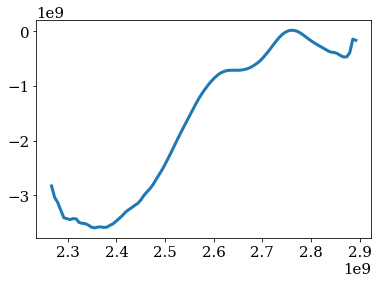

In [59]:
plt.plot(binm,V)

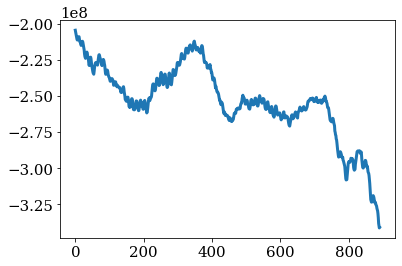

In [60]:
plt.plot(F)

Then use the fixed potential to calculate Landau Free energy over the full period

In [61]:
irightV = iJan1_2010+imin_right

In [62]:
MSEAtl_res = MSEAtl[ileftV-1:irightV+2,:,:].values # If can't fit in the memory, can't calculate potential
dMSE_dt = (MSEAtl_res[2:,:,:]-MSEAtl_res[:-2,:,:])/(2*dt)

In [63]:
Ffinal,binm_Ffinal,tmp = Landau.Landau_energy(MSEAtl_res,N_bins=30,V_fixed=V,bin_fixed=binm)

Compare Landau Free Energy calculated over the full period to contour

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

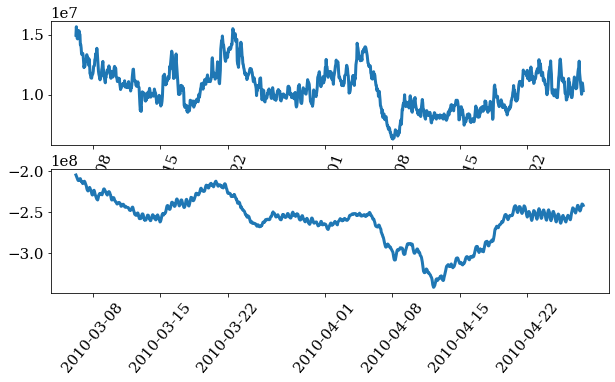

In [64]:
plt.figure(figsize=(10,5))
plt.subplot(2,1,1)
plt.plot(t2010[imin_left-1:imin_right],CON_data[2010][imin_left-1:imin_right])
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=70 )
plt.subplot(2,1,2)
plt.plot(t2010[imin_left-1:imin_right],Ffinal[1:-1])
plt.setp(plt.gca().xaxis.get_majorticklabels(), rotation=50 )

Accumulate PDF over the right bins to fill the potential

In [78]:
def bin_mid_to_edge(binm):
    bine = 0.5*(binm[:-1]+binm[1:]) # bin_edges[1:-1]
    return np.concatenate(([bine[0]-(bine[2]-bine[1])],bine,[bine[-1]+(bine[2]-bine[1])]))

In [79]:
bine = bin_mid_to_edge(binm)

In [80]:
MSE_PDF_LEFT,LEFTe = np.histogram(MSEAtl[(iJan1_2010+imin_left-24):(iJan1_2010+imin_left+24),:,:],bins=100,density=True)
MSE_PDF_MID,MIDe = np.histogram(MSEAtl[(iJan1_2010+imax-24):(iJan1_2010+imax+24),:,:],bins=100,density=True)
MSE_PDF_RIGHT,RIGHTe = np.histogram(MSEAtl[(iJan1_2010+imin_right-24):(iJan1_2010+imin_right+24),:,:],bins=100,density=True)

Paper Figures

In [82]:
SPINrgb = np.array([255,126,14])/255
COALrgb = np.array([43,160,43])/255
COARrgb = np.array([31,119,179])/255

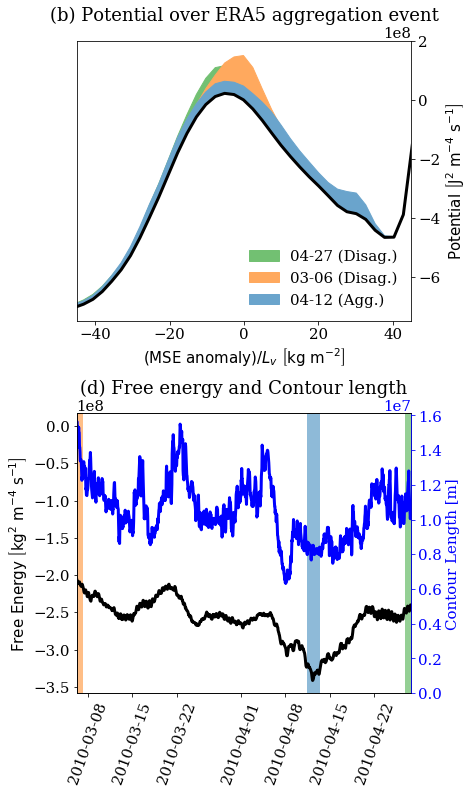

In [108]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(2,1,figsize=(6,12))
plt.subplots_adjust(hspace=0.33)

ax[0].plot((binm-bin0)/2.5e6,V,color='k')
ax[0].set_title('(b) Potential over ERA5 aggregation event',pad=20)
ax[0].set_xlabel(r'$\left(\mathrm{MSE\ anomaly}\right)/L_{v}\ \left[\mathrm{kg\ m^{-2}}\right]$')
ax[0].set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')
ax[0].yaxis.tick_right()
ax[0].yaxis.set_label_position("right")
ax[0].set_xlim((-45,45))
ax[0].set_ylim((-7.5e8,2e8))

ax[0].fill_between((binm-bin0)/2.5e6,V,V+MSE_PDF_RIGHT*1e16,color=1-(1-COALrgb)/1.5,label='04-27 (Disag.)')
ax[0].fill_between((binm-bin0)/2.5e6,V,V+MSE_PDF_LEFT*1e16,color=1-(1-SPINrgb)/1.5,label='03-06 (Disag.)')
ax[0].fill_between((binm-bin0)/2.5e6,V,V+MSE_PDF_MID*1e16,color=1-(1-COARrgb)/1.5,label='04-12 (Agg.)')
ax[0].legend(frameon=False)

axbis = ax[1].twinx(); X = t2010[imin_left-1:imin_right];
axbis.plot(X,CON_data[2010][imin_left-1:imin_right],color='b')
axbis.spines['right'].set_color('b')
axbis.tick_params(axis='y', colors='b')
axbis.set_ylim((0,axbis.get_ylim()[1]))
axbis.set_ylabel('Contour Length [m]',color='b')

ax[1].plot(t2010[imin_left-1:imin_right],Ffinal[1:-1],color='k')
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=70 )

# From https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/fill_between_demo.html
import matplotlib.transforms as mtransforms
trans = mtransforms.blended_transform_factory(ax[1].transData, ax[1].transAxes)
ax[1].fill_between(x=X.values,y1=0,y2=1,where=(X.values<=t2010[imin_left+24].values)&(X.values>=t2010[imin_left-24].values),
                   facecolor=SPINrgb,alpha=0.5,transform=trans)
ax[1].fill_between(x=X.values,y1=0,y2=1,where=(X.values<=t2010[imax+24].values)&(X.values>=t2010[imax-24].values),
                   facecolor=COARrgb,alpha=0.5,transform=trans)
ax[1].fill_between(x=X.values,y1=0,y2=1,where=(X.values<=t2010[imin_right+24].values)&(X.values>=t2010[imin_right-24].values),
                   facecolor=COALrgb,alpha=0.5,transform=trans)

ax[1].set_xlim((X.values.min(),X.values.max()))
ax[1].set_title('(d) Free energy and Contour length',pad=20)
ax[1].set_ylabel(r'$\mathrm{Free\ Energy\ \left[kg^{2}\ m^{-4}\ s^{-1}\right]}$')

# Save figure
path_home = '/home/tbeucler/'
plt.savefig(path_home+'Fig2b.pdf',format='pdf')

# 5) Figure 4: Composite pictures of the Atlantic ITCZ when aggregated/disaggregated based on both contour length and interquartile range

## 5.1) Only use JJA and pick top 5/bottom 5 based on IQ range

In [112]:
iJan1_2001 = index_date(MSEAtl.time,'2001-01-01T00:00:00')
iJun1_2001 = index_date(MSEAtl.time,'2001-06-01T00:00:00')
iSep1_2001 = index_date(MSEAtl.time,'2001-09-01T00:00:00')
iDec31_2001 = index_date(MSEAtl.time,'2001-12-31T23:00:00')

In [117]:
iJun1_2001,iSep1_2001,iDec31_2001,iJun1_2001[0]-iDec31_2001[0],iSep1_2001[0]-iDec31_2001[0]

([12408], [14616], [17543], -5135, -2927)

In [119]:
max_year = np.zeros((np.size(YEAR),))
min_year = np.zeros((np.size(YEAR),))

for i,year in enumerate(YEAR):
    max_year[i] = IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2928].max()
    min_year[i] = IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2928].min()

In [131]:
ARGmax = np.argsort(max_year/2.5e6)
SORmax = np.sort(max_year/2.5e6)
print(ARGmax,SORmax)

[13  2  7  0 18 12  9  3  8 15  5  6 11  1  4 16 14 17 10] [31.9955968 32.080128  32.2255872 32.5827584 33.0662912 33.111552
 33.330176  33.5905792 34.0322304 34.3560192 34.3851008 35.167232
 35.2598016 35.2707584 35.6544512 35.6793344 35.8977536 37.3412864
 37.8413056]


In [132]:
# Go through five top years and make sure there are no additional top events from June to August

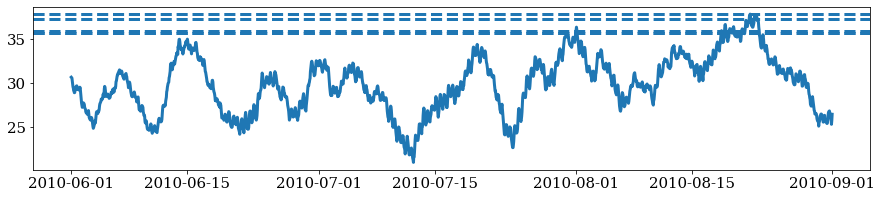

In [198]:
# Top 1 = 2010
year = 2010
date1 = str(year)+'-06-01T00:00:00'
date2 = str(year)+'-09-01T00:00:00'
tSummer = MSEAtl.time.sel({'time':slice(date1,date2)})
plt.figure(figsize=(15,3))
plt.plot(tSummer,IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
plt.axhline(y=SORmax[-1],linestyle='--')
plt.axhline(y=SORmax[-2],linestyle='--')
plt.axhline(y=SORmax[-3],linestyle='--')
plt.axhline(y=SORmax[-4],linestyle='--')
plt.axhline(y=SORmax[-5],linestyle='--')

The event around August 1st may possibly exceed the max from 2004

In [201]:
argmax2010_1 = np.argmax(IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
print('On ',tSummer[argmax2010_1].values,' IQ=',IQ_data['Interquartile_range_MSE'][str(year)][-5136+argmax2010_1]/2.5e6,'kg/m2',\
     'CON=',CON_data[year][-5136+argmax2010_1]/1e6,'Gm')

argmax2010_2 = np.argmax(IQ_data['Interquartile_range_MSE'][str(year)][-5136:-3500]/2.5e6)
print('On ',tSummer[argmax2010_2].values,' IQ=',IQ_data['Interquartile_range_MSE'][str(year)][-5136+argmax2010_2]/2.5e6,'kg/m2',\
     'CON=',CON_data[year][-5136+argmax2010_2]/1e6,'Gm')

On  2010-08-22T02:00:00.000000000  IQ= 37.8413056 kg/m2 CON= 4.9433725 Gm
On  2010-08-01T02:00:00.000000000  IQ= 36.363136 kg/m2 CON= 8.4695325 Gm


Text(0, 0.5, '$\\mathrm{Precipitation\\ \\left[mm\\ day^{-1}\\right]}$')

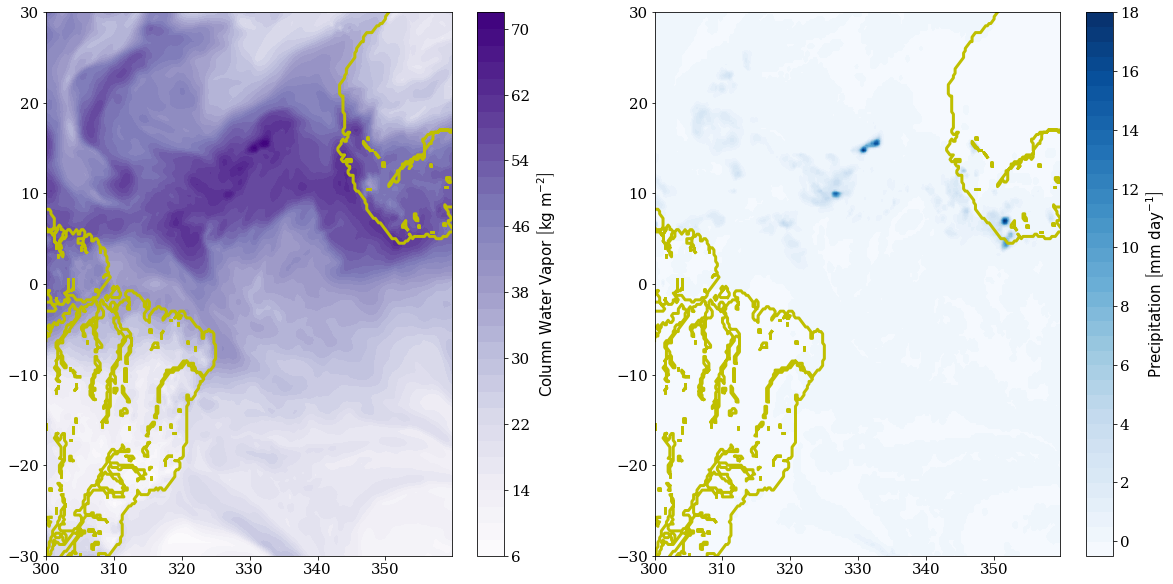

In [252]:
# Column water vapor and precipitation fields during the most organized days
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

dx = 110/4
date = '2010-08-22T02:00:00.000000000'
Land = curve.get_contours(LSM.lsm.sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})[0,:,:]>0.99)

fig,ax = plt.subplots(1,2,figsize=(20,10))

# Subplot 1 = CWV
for j,contour in enumerate(Land):
    ax[0].plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='y')
CWVplot = ax[0].contourf(lonAtl,latAtl,(CWVAtl.sel({'time':date})),cmap='Purples',levels=40)
cbar = fig.colorbar(CWVplot,ax=ax[0])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel(r'$\mathrm{Column\ Water\ Vapor\ \left[kg\ m^{-2}\right]}$', rotation=90)

# Subplot 2 = Precip
for j,contour in enumerate(Land):
    ax[1].plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='y')
Pplot = ax[1].contourf(lonAtl,latAtl,(PRECAtl.sel({'time':date})),cmap='Blues',levels=40)
cbar = fig.colorbar(Pplot,ax=ax[1])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel(r'$\mathrm{Precipitation\ \left[mm\ day^{-1}\right]}$', rotation=90)

Text(0, 0.5, '$\\mathrm{Precipitation\\ \\left[mm\\ day^{-1}\\right]}$')

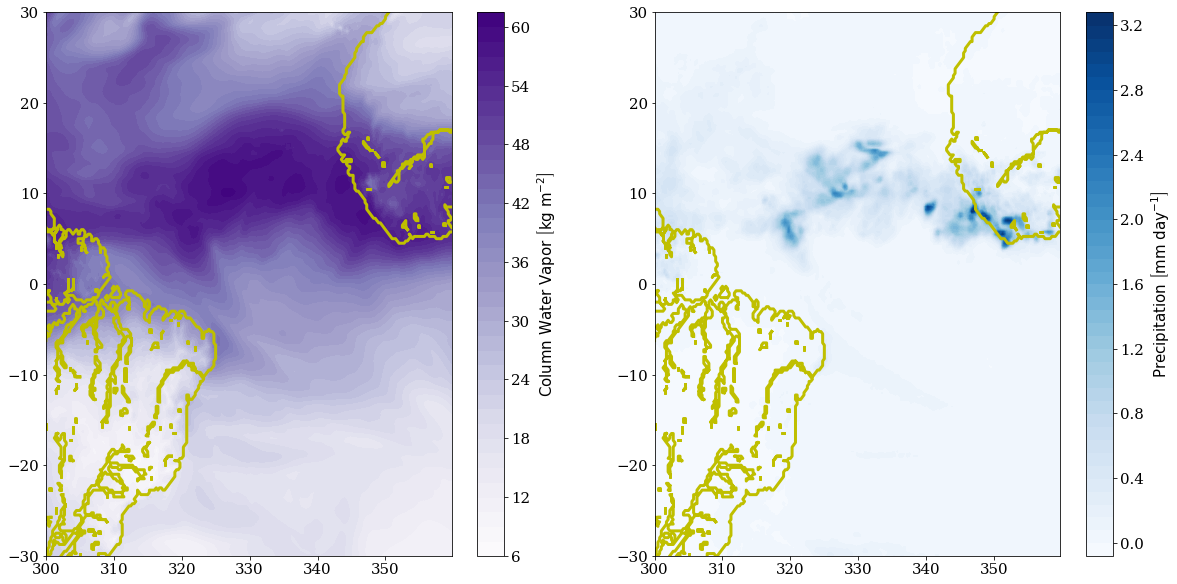

In [251]:
# Repeat for mean over 48 hours to create composite
# Column water vapor and precipitation fields during the most organized days
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

dx = 110/4
date = '2010-08-22T02:00:00.000000000'
date1 = str(np.datetime64(date)-np.timedelta64(1,'D'))
date2 = str(np.datetime64(date)+np.timedelta64(1,'D'))
Land = curve.get_contours(LSM.lsm.sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})[0,:,:]>0.99)

fig,ax = plt.subplots(1,2,figsize=(20,10))

# Subplot 1 = CWV
for j,contour in enumerate(Land):
    ax[0].plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='y')
CWVplot = ax[0].contourf(lonAtl,latAtl,(CWVAtl.sel({'time':slice(date1,date2)}).mean(dim='time')),cmap='Purples',levels=40)
cbar = fig.colorbar(CWVplot,ax=ax[0])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel(r'$\mathrm{Column\ Water\ Vapor\ \left[kg\ m^{-2}\right]}$', rotation=90)

# Subplot 2 = Precip
for j,contour in enumerate(Land):
    ax[1].plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='y')
Pplot = ax[1].contourf(lonAtl,latAtl,(PRECAtl.sel({'time':slice(date1,date2)}).mean(dim='time')),cmap='Blues',levels=40)
cbar = fig.colorbar(Pplot,ax=ax[1])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel(r'$\mathrm{Precipitation\ \left[mm\ day^{-1}\right]}$', rotation=90)

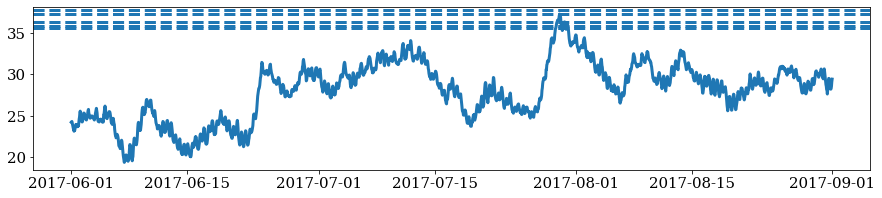

In [208]:
# Top 2 = 2017
year = 2017
date1 = str(year)+'-06-01T00:00:00'
date2 = str(year)+'-09-01T00:00:00'
tSummer = MSEAtl.time.sel({'time':slice(date1,date2)})
plt.figure(figsize=(15,3))
plt.plot(tSummer,IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
plt.axhline(y=SORmax[-1],linestyle='--')
plt.axhline(y=SORmax[-2],linestyle='--')
plt.axhline(y=SORmax[-3],linestyle='--')
plt.axhline(y=SORmax[-4],linestyle='--')
plt.axhline(y=IQ_data['Interquartile_range_MSE'][str(2010)][-5136+argmax2010_2]/2.5e6,linestyle='--')

In [209]:
argmax2017_1 = np.argmax(IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
print('On ',tSummer[argmax2017_1].values,' IQ=',IQ_data['Interquartile_range_MSE'][str(year)][-5136+argmax2017_1]/2.5e6,'kg/m2',\
     'CON=',CON_data[year][-5136+argmax2017_1]/1e6,'Gm')

On  2017-07-30T01:00:00.000000000  IQ= 37.3412864 kg/m2 CON= 6.6619025 Gm


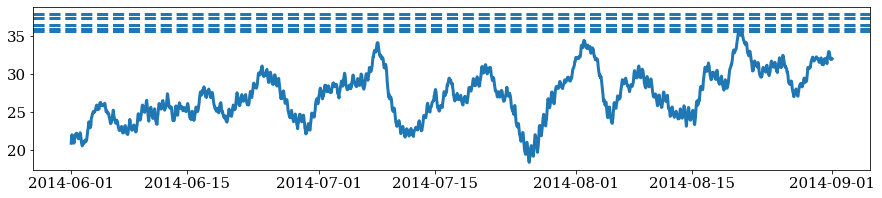

In [210]:
# Top 4 = 2014
year = 2014
date1 = str(year)+'-06-01T00:00:00'
date2 = str(year)+'-09-01T00:00:00'
tSummer = MSEAtl.time.sel({'time':slice(date1,date2)})
plt.figure(figsize=(15,3))
plt.plot(tSummer,IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
plt.axhline(y=SORmax[-1],linestyle='--')
plt.axhline(y=SORmax[-2],linestyle='--')
plt.axhline(y=SORmax[-3],linestyle='--')
plt.axhline(y=SORmax[-4],linestyle='--')
plt.axhline(y=IQ_data['Interquartile_range_MSE'][str(2010)][-5136+argmax2010_2]/2.5e6,linestyle='--')

In [211]:
argmax2014_1 = np.argmax(IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
print('On ',tSummer[argmax2014_1].values,' IQ=',IQ_data['Interquartile_range_MSE'][str(year)][-5136+argmax2014_1]/2.5e6,'kg/m2',\
     'CON=',CON_data[year][-5136+argmax2014_1]/1e6,'Gm')

On  2014-08-21T01:00:00.000000000  IQ= 35.8977536 kg/m2 CON= 7.3915875 Gm


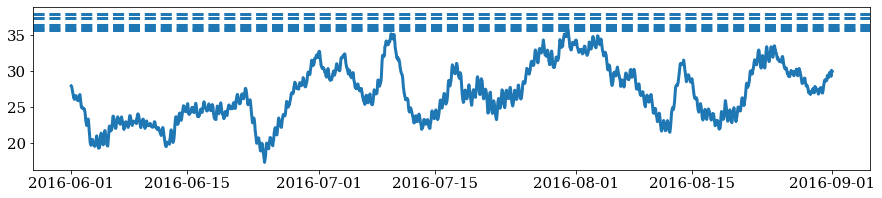

In [212]:
# Top 5 = 2016
year = 2016
date1 = str(year)+'-06-01T00:00:00'
date2 = str(year)+'-09-01T00:00:00'
tSummer = MSEAtl.time.sel({'time':slice(date1,date2)})
plt.figure(figsize=(15,3))
plt.plot(tSummer,IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
plt.axhline(y=SORmax[-1],linestyle='--')
plt.axhline(y=SORmax[-2],linestyle='--')
plt.axhline(y=SORmax[-3],linestyle='--')
plt.axhline(y=SORmax[-4],linestyle='--')
plt.axhline(y=IQ_data['Interquartile_range_MSE'][str(2010)][-5136+argmax2010_2]/2.5e6,linestyle='--')

In [213]:
argmax2016_1 = np.argmax(IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
print('On ',tSummer[argmax2016_1].values,' IQ=',IQ_data['Interquartile_range_MSE'][str(year)][-5136+argmax2016_1]/2.5e6,'kg/m2',\
     'CON=',CON_data[year][-5136+argmax2016_1]/1e6,'Gm')

On  2016-07-31T00:00:00.000000000  IQ= 35.6793344 kg/m2 CON= 7.4905875 Gm


In [260]:
year_array = [2010,2010,2017,2014,2016]
imaxIQ_array = [argmax2010_1,argmax2010_2,argmax2017_1,argmax2014_1,argmax2016_1]
date_array = []; IQ_array = []; CON_array = []
for i,year in enumerate(year_array):
    imaxIQ = imaxIQ_array[i]
    date_array += [str(tSummer[imaxIQ].values)]
    IQ_array += [(IQ_data['Interquartile_range_MSE'][str(year)][-5136+imaxIQ]/2.5e6)]
    CON_array += [CON_data[year][-5136+imaxIQ]/1e6]
IQ_array = np.array(IQ_array)
CON_array = np.array(CON_array)

In [194]:
# Composite mean figure
for i,date in enumerate(date_array):
    print('i=',i,'& date=',date,'               ',end='\r')
    date1 = str(np.datetime64(date)-np.timedelta64(1,'D'))
    date2 = str(np.datetime64(date)+np.timedelta64(1,'D'))
    if i==0: 
        CWVmaxIQ = CWVAtl.sel({'time':slice(date1,date2)}).mean(dim='time').values
        PmaxIQ = PRECAtl.sel({'time':slice(date1,date2)}).mean(dim='time').values
    else: 
        CWVmaxIQ += CWVAtl.sel({'time':slice(date1,date2)}).mean(dim='time').values
        PmaxIQ += PRECAtl.sel({'time':slice(date1,date2)}).mean(dim='time').values
        
CWVmaxIQ = CWVmaxIQ/np.size(date_array)
PmaxIQ = PmaxIQ/np.size(date_array)

Text(0, 0.5, '$\\mathrm{Precipitation\\ \\left[mm\\ day^{-1}\\right]}$')

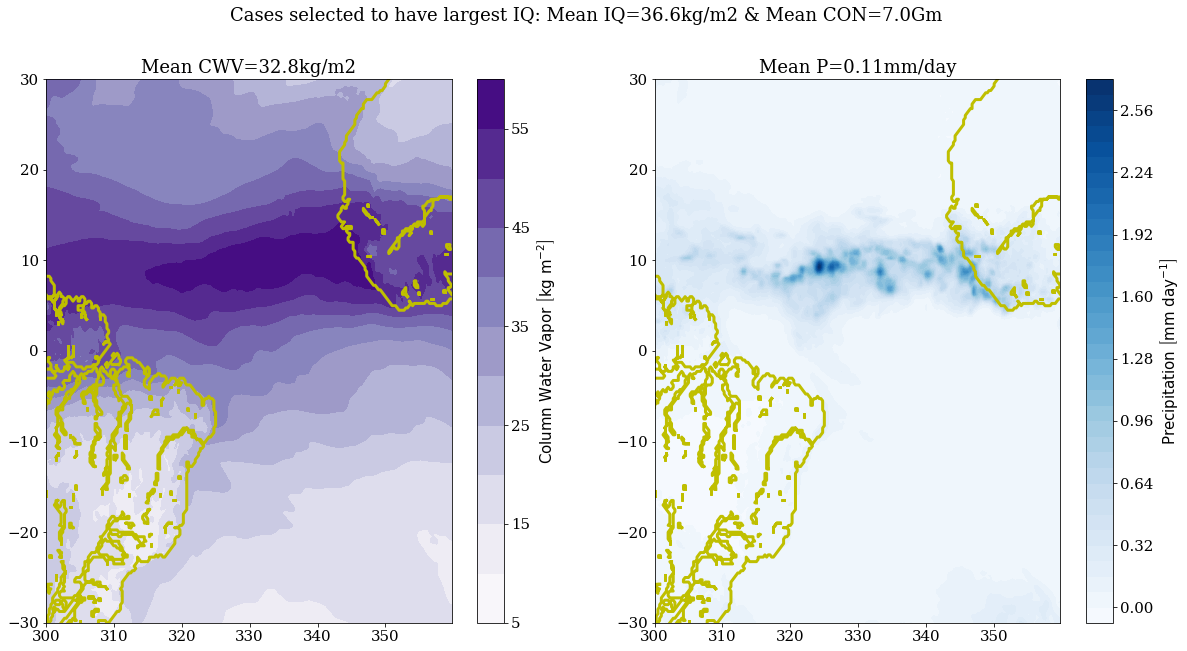

In [266]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(1,2,figsize=(20,10))

fig.suptitle("Cases selected to have largest IQ: Mean IQ="+"%03.1f"%(IQ_array.mean())+"kg/m2 & Mean CON="+"%03.1f"%(CON_array.mean())+"Gm")

# Subplot 1 = CWV
for j,contour in enumerate(Land):
    ax[0].plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='y')
CWVplot = ax[0].contourf(lonAtl,latAtl,CWVmaxIQ,cmap='Purples',levels=10)
ax[0].set_title('Mean CWV='+"%03.1f"%(CWVmaxIQ.mean())+'kg/m2')
cbar = fig.colorbar(CWVplot,ax=ax[0])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel(r'$\mathrm{Column\ Water\ Vapor\ \left[kg\ m^{-2}\right]}$', rotation=90)

# Subplot 2 = Precip
for j,contour in enumerate(Land):
    ax[1].plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='y')
Pplot = ax[1].contourf(lonAtl,latAtl,PmaxIQ,cmap='Blues',levels=40)
ax[1].set_title('Mean P='+"%02.2f"%(PmaxIQ.mean())+'mm/day')
cbar = fig.colorbar(Pplot,ax=ax[1])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel(r'$\mathrm{Precipitation\ \left[mm\ day^{-1}\right]}$', rotation=90)

In [269]:
ARGmin = np.argsort(min_year/2.5e6)
SORmin = np.sort(min_year/2.5e6)
print(ARGmin,'\n',SORmin)

[ 1  2 16  9  7 14 18 12 15  3 17  0  4 13  6  5 10 11  8] 
 [16.3239936 17.0873856 17.2761088 18.1561344 18.206208  18.3058432
 18.3771136 18.3902208 18.6266624 18.8294144 19.2987136 19.6634368
 19.8815744 20.1665536 20.9246208 20.9944576 21.0143232 21.3602304
 21.8033152]


In [270]:
# Go through five bottom years to check the additional bottom events from June to August

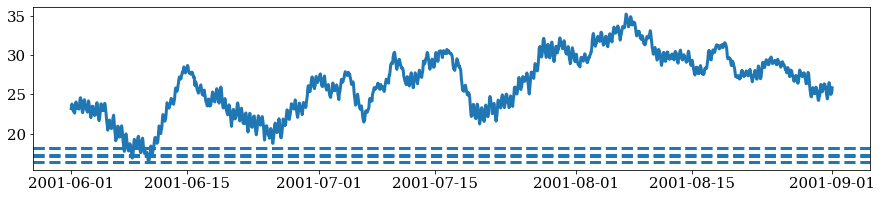

In [271]:
# Bottom 1 = 2001
year = 2001
date1 = str(year)+'-06-01T00:00:00'
date2 = str(year)+'-09-01T00:00:00'
tSummer = MSEAtl.time.sel({'time':slice(date1,date2)})
plt.figure(figsize=(15,3))
plt.plot(tSummer,IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
plt.axhline(y=SORmin[0],linestyle='--')
plt.axhline(y=SORmin[1],linestyle='--')
plt.axhline(y=SORmin[2],linestyle='--')
plt.axhline(y=SORmin[3],linestyle='--')
plt.axhline(y=SORmin[4],linestyle='--')

In [272]:
argmin2001_1 = np.argmin(IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
print('On ',tSummer[argmin2001_1].values,' IQ=',IQ_data['Interquartile_range_MSE'][str(year)][-5136+argmin2001_1]/2.5e6,'kg/m2',\
     'CON=',CON_data[year][-5136+argmin2001_1]/1e6,'Gm')

On  2001-06-10T09:00:00.000000000  IQ= 16.3239936 kg/m2 CON= 12.2383525 Gm


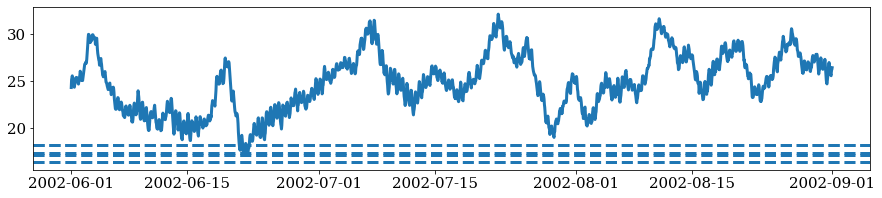

In [273]:
# Bottom 2 = 2002
year = 2002
date1 = str(year)+'-06-01T00:00:00'
date2 = str(year)+'-09-01T00:00:00'
tSummer = MSEAtl.time.sel({'time':slice(date1,date2)})
plt.figure(figsize=(15,3))
plt.plot(tSummer,IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
plt.axhline(y=SORmin[0],linestyle='--')
plt.axhline(y=SORmin[1],linestyle='--')
plt.axhline(y=SORmin[2],linestyle='--')
plt.axhline(y=SORmin[3],linestyle='--')
plt.axhline(y=SORmin[4],linestyle='--')

In [274]:
argmin2002_1 = np.argmin(IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
print('On ',tSummer[argmin2002_1].values,' IQ=',IQ_data['Interquartile_range_MSE'][str(year)][-5136+argmin2002_1]/2.5e6,'kg/m2',\
     'CON=',CON_data[year][-5136+argmin2002_1]/1e6,'Gm')

On  2002-06-21T22:00:00.000000000  IQ= 17.0873856 kg/m2 CON= 9.772565 Gm


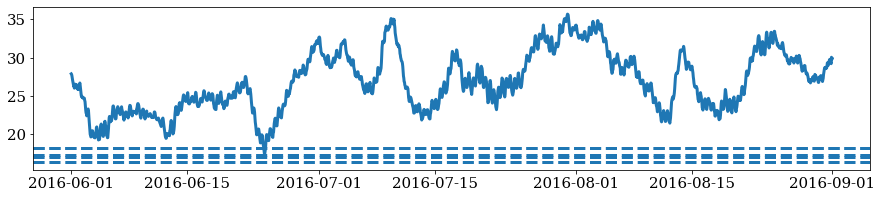

In [275]:
# Bottom 3 = 2016
year = 2016
date1 = str(year)+'-06-01T00:00:00'
date2 = str(year)+'-09-01T00:00:00'
tSummer = MSEAtl.time.sel({'time':slice(date1,date2)})
plt.figure(figsize=(15,3))
plt.plot(tSummer,IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
plt.axhline(y=SORmin[0],linestyle='--')
plt.axhline(y=SORmin[1],linestyle='--')
plt.axhline(y=SORmin[2],linestyle='--')
plt.axhline(y=SORmin[3],linestyle='--')
plt.axhline(y=SORmin[4],linestyle='--')

In [276]:
argmin2016_1 = np.argmin(IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
print('On ',tSummer[argmin2016_1].values,' IQ=',IQ_data['Interquartile_range_MSE'][str(year)][-5136+argmin2016_1]/2.5e6,'kg/m2',\
     'CON=',CON_data[year][-5136+argmin2016_1]/1e6,'Gm')

On  2016-06-24T09:00:00.000000000  IQ= 17.2761088 kg/m2 CON= 16.52563 Gm


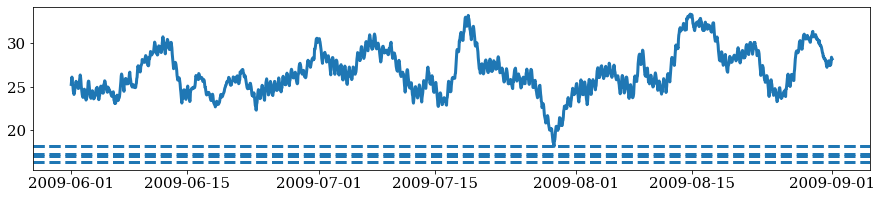

In [277]:
# Bottom 4 = 2009
year = 2009
date1 = str(year)+'-06-01T00:00:00'
date2 = str(year)+'-09-01T00:00:00'
tSummer = MSEAtl.time.sel({'time':slice(date1,date2)})
plt.figure(figsize=(15,3))
plt.plot(tSummer,IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
plt.axhline(y=SORmin[0],linestyle='--')
plt.axhline(y=SORmin[1],linestyle='--')
plt.axhline(y=SORmin[2],linestyle='--')
plt.axhline(y=SORmin[3],linestyle='--')
plt.axhline(y=SORmin[4],linestyle='--')

In [278]:
argmin2009_1 = np.argmin(IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
print('On ',tSummer[argmin2009_1].values,' IQ=',IQ_data['Interquartile_range_MSE'][str(year)][-5136+argmin2009_1]/2.5e6,'kg/m2',\
     'CON=',CON_data[year][-5136+argmin2009_1]/1e6,'Gm')

On  2009-07-29T09:00:00.000000000  IQ= 18.1561344 kg/m2 CON= 16.259815 Gm


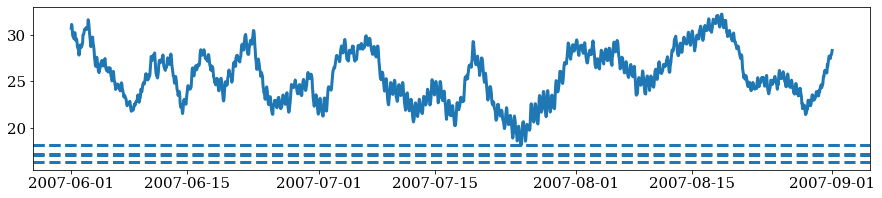

In [279]:
# Bottom 4 = 2007
year = 2007
date1 = str(year)+'-06-01T00:00:00'
date2 = str(year)+'-09-01T00:00:00'
tSummer = MSEAtl.time.sel({'time':slice(date1,date2)})
plt.figure(figsize=(15,3))
plt.plot(tSummer,IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
plt.axhline(y=SORmin[0],linestyle='--')
plt.axhline(y=SORmin[1],linestyle='--')
plt.axhline(y=SORmin[2],linestyle='--')
plt.axhline(y=SORmin[3],linestyle='--')
plt.axhline(y=SORmin[4],linestyle='--')

In [280]:
argmin2007_1 = np.argmin(IQ_data['Interquartile_range_MSE'][str(year)][-5136:-2927]/2.5e6)
print('On ',tSummer[argmin2007_1].values,' IQ=',IQ_data['Interquartile_range_MSE'][str(year)][-5136+argmin2007_1]/2.5e6,'kg/m2',\
     'CON=',CON_data[year][-5136+argmin2007_1]/1e6,'Gm')

On  2007-07-25T10:00:00.000000000  IQ= 18.206208 kg/m2 CON= 10.5548025 Gm


In [281]:
print(ARGmin,'\n',SORmin)

[ 1  2 16  9  7 14 18 12 15  3 17  0  4 13  6  5 10 11  8] 
 [16.3239936 17.0873856 17.2761088 18.1561344 18.206208  18.3058432
 18.3771136 18.3902208 18.6266624 18.8294144 19.2987136 19.6634368
 19.8815744 20.1665536 20.9246208 20.9944576 21.0143232 21.3602304
 21.8033152]


In [282]:
year_array = [2001,2002,2016,2009,2007]
iminIQ_array = [argmin2001_1,argmin2002_1,argmin2016_1,argmin2009_1,argmin2007_1]
date_array = []; IQ_array = []; CON_array = []
for i,year in enumerate(year_array):
    iminIQ = iminIQ_array[i]
    date_array += [str(tSummer[iminIQ].values)]
    IQ_array += [(IQ_data['Interquartile_range_MSE'][str(year)][-5136+iminIQ]/2.5e6)]
    CON_array += [CON_data[year][-5136+iminIQ]/1e6]
IQ_array = np.array(IQ_array)
CON_array = np.array(CON_array)

In [283]:
# Composite mean figure
for i,date in enumerate(date_array):
    print('i=',i,'& date=',date,'               ',end='\r')
    date1 = str(np.datetime64(date)-np.timedelta64(1,'D'))
    date2 = str(np.datetime64(date)+np.timedelta64(1,'D'))
    if i==0: 
        CWVminIQ = CWVAtl.sel({'time':slice(date1,date2)}).mean(dim='time').values
        PminIQ = PRECAtl.sel({'time':slice(date1,date2)}).mean(dim='time').values
    else: 
        CWVminIQ += CWVAtl.sel({'time':slice(date1,date2)}).mean(dim='time').values
        PminIQ += PRECAtl.sel({'time':slice(date1,date2)}).mean(dim='time').values
        
CWVminIQ = CWVminIQ/np.size(date_array)
PminIQ = PminIQ/np.size(date_array)

Text(0, 0.5, '$\\mathrm{Precipitation\\ \\left[mm\\ day^{-1}\\right]}$')

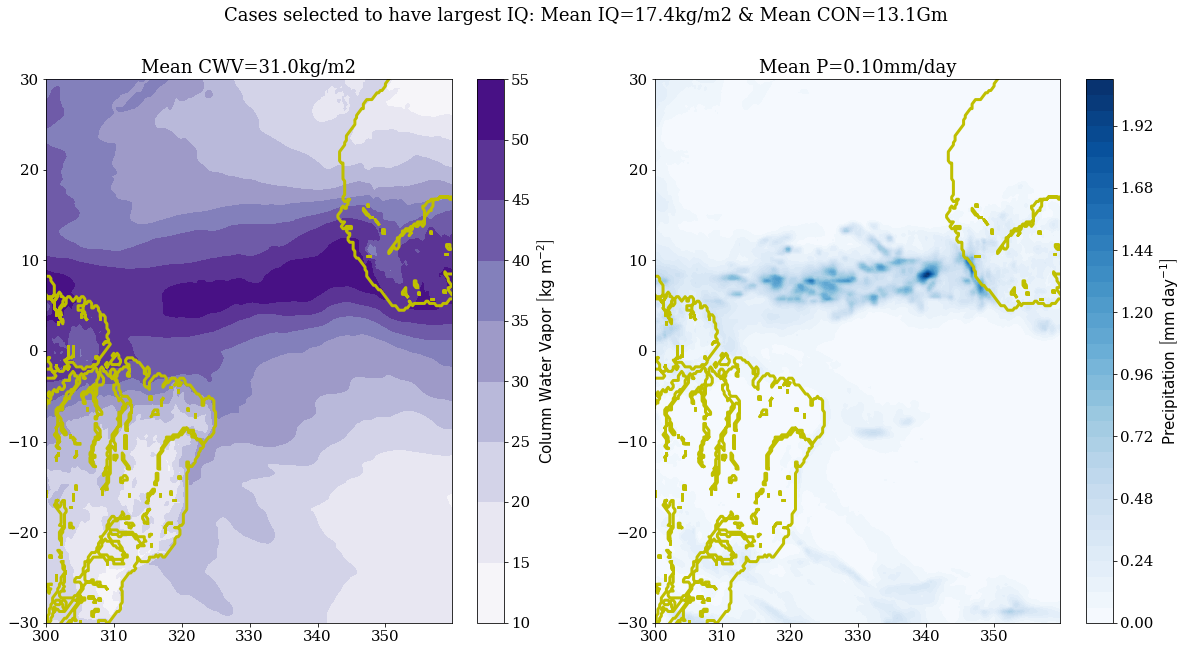

In [284]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(1,2,figsize=(20,10))

fig.suptitle("Cases selected to have largest IQ: Mean IQ="+"%03.1f"%(IQ_array.mean())+"kg/m2 & Mean CON="+"%03.1f"%(CON_array.mean())+"Gm")

# Subplot 1 = CWV
for j,contour in enumerate(Land):
    ax[0].plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='y')
CWVplot = ax[0].contourf(lonAtl,latAtl,CWVminIQ,cmap='Purples',levels=10)
ax[0].set_title('Mean CWV='+"%03.1f"%(CWVminIQ.mean())+'kg/m2')
cbar = fig.colorbar(CWVplot,ax=ax[0])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel(r'$\mathrm{Column\ Water\ Vapor\ \left[kg\ m^{-2}\right]}$', rotation=90)

# Subplot 2 = Precip
for j,contour in enumerate(Land):
    ax[1].plot(lonAtl[contour[:,1].astype(int)],latAtl[contour[:,0].astype(int)],color='y')
Pplot = ax[1].contourf(lonAtl,latAtl,PminIQ,cmap='Blues',levels=40)
ax[1].set_title('Mean P='+"%02.2f"%(PminIQ.mean())+'mm/day')
cbar = fig.colorbar(Pplot,ax=ax[1])
cbar.ax.get_yaxis().labelpad = 5
cbar.ax.set_ylabel(r'$\mathrm{Precipitation\ \left[mm\ day^{-1}\right]}$', rotation=90)